# 基于突变的模糊测试

大多数 [随机生成的输入](Fuzzer.ipynb) 都是词法 _无效_ 的，它们很快就会被目标程序拒绝。要使目标程序能够很好地处理输入，我们必须增加获得有效输入的概率。其中一种方法就叫做 *突变的模糊测试* --- 也就是说，对现有输入进行细微的更改，这些更改可能仍使输入保持有效，但仍具有新的行为。 我们将展示如何创建此类突变，以及如何使用流行的AFL模糊器的核心概念来引导它们走向尚未发现的代码。

**预备知识**

* 你应该了解模糊测试的基本工作原理。比如，熟知 ["模糊测试"](Fuzzer.ipynb) 章节中的概念

## 简介
<!-- Automatically generated. Do not edit. -->

为了 [使用本章节的代码](Importing.ipynb)， 导入

```python
>>> from fuzzingbook.MutationFuzzer import <identifier>
```

然后就可以使用相关特性了。

本章介绍一个 `MutationFuzzer` 类，该类输入一些 _种子文件_ 然后对它们进行突变操作。

```python
>>> seed_input = "http://www.google.com/search?q=fuzzing"
>>> mutation_fuzzer = MutationFuzzer(seed=[seed_input])
>>> [mutation_fuzzer.fuzz() for i in range(10)]
['http://www.google.com/search?q=fuzzing',
 'http://www.g=oNogl.om/search?q=fuzzing/',
 'RttpX://w)ww.goo(gle.comq/sarc(q=fuzzng',
 'hdt8p://"wWw.goole.com/seDarb`*?q=fuzzing',
 'httop://www.CooglGe.om/s$arch?q=fuzzingY',
 'http://wwlw.google.c"om/secrch?yq=fuzzin',
 'hup://www.google.comC/search?q=fuzzing',
 'http://w7w.google.com/search?q=ufuzgzing',
 'http://www,google.com/sear4ch?.q=fuzzing',
 'http://w&ww.google.cKom/search7q=fuzzing']
```
`MutationCoverageFuzzer` 包含输入的 _数量_ ，然后对其进行演化以达到最大化覆盖范围。

```python
>>> mutation_fuzzer = MutationCoverageFuzzer(seed=[seed_input])
>>> mutation_fuzzer.runs(http_runner, trials=10000)
>>> mutation_fuzzer.population[:5]
['http://www.google.com/search?q=fuzzing',
 'htTp://www.googld.cqom/searchq=fuzzIng',
 'htTp://www.gloogld.qom/|searchq=fuzzng',
 'htTp://www.googld.cqomo0searchq=fuzzIng',
 'htTp://www*goegld.cqoe/sa7#hq=fuzIng']
```


## 使用突变操作进行模糊测试

在2013年11月， [American Fuzzy Lop](http://lcamtuf.coredump.cx/afl/) (AFL) 第一版发布了。从这以后， AFL已成为最成功的模糊测试工具之一，并具有多种演变，例如，[AFLFast](https://github.com/mboehme/aflfast), [AFLGo](https://github.com/aflgo/aflgo), and [AFLSmart](https://github.com/aflsmart/aflsmart) (都将在本书讨论)。AFL使模糊测试成为自动漏洞检测的最佳选择。它是第一个证明可以在许多对安全性要求很高的实际应用程序中大规模自动检测漏洞的工具。

![American Fuzzy Lop Command Line User Interface](PICS/afl_screen.png)
<center><b>Figure 1.</b> American Fuzzy Lop 命令行用户界面</center>

在本章中，我们将介绍突变模糊测试的基础。接下来的下一章将进一步说明如何将模糊测试引导到特定的代码目标。

## 对 URL 解析器进行 Fuzzing

许多程序期望它们的输入以非常特定的格式输入，然后才能具体处理它们。例如，考虑一个接受URL（Web地址）的程序。该URL必须采用有效格式（即URL格式），以便程序能够对其进行处理。当使用随机输入进行模糊测试时，我们实际产生有效URL的机会是多少？

为了更深入地研究这个问题，让我们探索一下URL的组成。 URL由许多元素组成：

    scheme://netloc/path?query#fragment
    
where

* `scheme` 使用的网络协议，比如 `http`, `https`, `ftp`, `file`...
* `netloc` 表示要连接的主机名，如 `www.google.com`
* `path` 表示要访问的主机路径，如 `search`
* `query` 是 一组 key/value 对，如 `q=fuzzing`
* `fragment` 是所检索文档中某个位置的标记，如 `#result`

 在 Python 中，我们可以使用  `urlparse()` 函数去解析和组成URL的特定部分。

In [1]:
import fuzzingbook_utils

In [2]:
try:
    from urlparse import urlparse      # Python 2
except ImportError:
    from urllib.parse import urlparse  # Python 3

urlparse("http://www.google.com/search?q=fuzzing")

ParseResult(scheme='http', netloc='www.google.com', path='/search', params='', query='q=fuzzing', fragment='')

下面我们将看到结果如何将URL的各个部分编码为不同的属性。

现在我们假设我们有一个使用URL作为输入的程序。为简化起见，我们不会让它做太多事情。我们只是让它检查传递的URL的有效性。如果URL有效，则返回True；否则，将引发异常。

In [3]:
def http_program(url):
    supported_schemes = ["http", "https"]
    result = urlparse(url)
    if result.scheme not in supported_schemes:
        raise ValueError("Scheme must be one of " + repr(supported_schemes))
    if result.netloc == '':
        raise ValueError("Host must be non-empty")

    # Do something with the URL
    return True

我们现在开始 fuzz `http_program()`。为了开始 fuzz，我们使用了所有可打印的ASCII字符，包括`：`，`/`和小写字母。

In [4]:
from Fuzzer import fuzzer

In [5]:
fuzzer(char_start=32, char_range=96)

'"N&+slk%h\x7fyp5o\'@[3(rW*M5W]tMFPU4\\P@tz%[X?uo\\1?b4T;1bDeYtHx #UJ5w}pMmPodJM,_'

让我们尝试对1000个随机输入进行模糊测试，看看我们能否得到一些成功的例子。

In [6]:
for i in range(1000):
    try:
        url = fuzzer()
        result = http_program(url)
        print("Success!")
    except ValueError:
        pass

实际获得有效URL的概率是多少？ 我们需要以字符串 `"http://"` or `"https://"` 开头。我们首先来计算以 `"http://"` 开头的例子。这是我们需要开始的七个非常具体的字符。随机产生这七个字符（字符范围为96个不同字符）的概率为$ 1：96^7 $，或者

In [7]:
96 ** 7

75144747810816

产生 `"https://"` 前缀的概率更小，为 $1 : 96^8$:

In [8]:
96 ** 8

7213895789838336

总的概率为：

In [9]:
likelihood = 1 / (96 ** 7) + 1 / (96 ** 8)
likelihood

1.344627131107667e-14

这是我们产生有效的URL方案所需的运行次数（平均）：

In [10]:
1 / likelihood

74370059689055.02

我们来计算一下执行一次 `http_program()` 需要多久：

In [11]:
from Timer import Timer

In [12]:
trials = 1000
with Timer() as t:
    for i in range(trials):
        try:
            url = fuzzer()
            result = http_program(url)
            print("Success!")
        except ValueError:
            pass

duration_per_run_in_seconds = t.elapsed_time() / trials
duration_per_run_in_seconds

6.154701000195927e-05

那非常快，不是吗？ 不幸的是，我们有很多需要解决的问题。

In [13]:
seconds_until_success = duration_per_run_in_seconds * (1 / likelihood)
seconds_until_success

4577254807.528577

转换一下单位：

In [14]:
hours_until_success = seconds_until_success / 3600
days_until_success = hours_until_success / 24
years_until_success = days_until_success / 365.25
years_until_success

145.04445228815172

即使我们并行处理很多事情，我们仍需要等待数月至数年。为了使程序能够成功执行 `http_program()` 的执行时间会更久。

基本的模糊测试最好是测试 `urlparse()` ，如果此解析函数中有错误，则很有可能将其发现。但是，只要我们无法产生有效的输入，我们就无法达到任何更深层次的测试效果。

## 输入突变

从头开始生成随机字符串的替代方法是从给定的 _有效_ 输入开始的，然后对其进行 _变异_ 。 在这种情况下， _变异_ 是一种简单的字符串操作---例如，插入（随机）字符，删除字符或在字符表示中翻转一位。 这被称为*突变模糊测试* --- 与之前讨论的``生成模糊测试``技术相反。

以下是一些可以帮助你入门的突变操作：

In [15]:
import random

In [16]:
def delete_random_character(s):
    """Returns s with a random character deleted"""
    if s == "":
        return s

    pos = random.randint(0, len(s) - 1)
    # print("Deleting", repr(s[pos]), "at", pos)
    return s[:pos] + s[pos + 1:]

In [17]:
seed_input = "A quick brown fox"
for i in range(10):
    x = delete_random_character(seed_input)
    print(repr(x))

'A uick brown fox'
'A quic brown fox'
'A quick brown fo'
'A quic brown fox'
'A quick bown fox'
'A quick bown fox'
'A quick brown fx'
'A quick brown ox'
'A quick brow fox'
'A quic brown fox'


In [18]:
def insert_random_character(s):
    """Returns s with a random character inserted"""
    pos = random.randint(0, len(s))
    random_character = chr(random.randrange(32, 127))
    # print("Inserting", repr(random_character), "at", pos)
    return s[:pos] + random_character + s[pos:]

In [19]:
for i in range(10):
    print(repr(insert_random_character(seed_input)))

'A quick brvown fox'
'A quwick brown fox'
'A qBuick brown fox'
'A quick broSwn fox'
'A quick brown fvox'
'A quick brown 3fox'
'A quick brNown fox'
'A quick brow4n fox'
'A quick brown fox8'
'A equick brown fox'


In [20]:
def flip_random_character(s):
    """Returns s with a random bit flipped in a random position"""
    if s == "":
        return s

    pos = random.randint(0, len(s) - 1)
    c = s[pos]
    bit = 1 << random.randint(0, 6)
    new_c = chr(ord(c) ^ bit)
    # print("Flipping", bit, "in", repr(c) + ", giving", repr(new_c))
    return s[:pos] + new_c + s[pos + 1:]


In [21]:
for i in range(10):
    print(repr(flip_random_character(seed_input)))

'A quick bRown fox'
'A quici brown fox'
'A"quick brown fox'
'A quick brown$fox'
'A quick bpown fox'
'A quick brown!fox'
'A 1uick brown fox'
'@ quick brown fox'
'A quic+ brown fox'
'A quick bsown fox'


现在我们创建一个随机突变器，它随机选择要应用的变异操作：

In [22]:
def mutate(s):
    """Return s with a random mutation applied"""
    mutators = [
        delete_random_character,
        insert_random_character,
        flip_random_character
    ]
    mutator = random.choice(mutators)
    # print(mutator)
    return mutator(s)

In [23]:
for i in range(10):
    print(repr(mutate("A quick brown fox")))

'A qzuick brown fox'
' quick brown fox'
'A quick Brown fox'
'A qMuick brown fox'
'A qu_ick brown fox'
'A quick bXrown fox'
'A quick brown fx'
'A quick!brown fox'
'A! quick brown fox'
'A quick brownfox'


现在的想法是，如果开始时有一些有效输入，则可以通过应用上述突变之一来创建更多输入候选。要了解其工作原理，让我们回到URL。

## 突变 URLs

我们重新回到 URL 解析问题。我们编写一个函数 `is_valid_url()` 来检查 `http_program()` 是否接收某个输入。

In [24]:
def is_valid_url(url):
    try:
        result = http_program(url)
        return True
    except ValueError:
        return False

In [25]:
assert is_valid_url("http://www.google.com/search?q=fuzzing")
assert not is_valid_url("xyzzy")

现在我们使用 `mutate()` 函数对 URL 进行变异，我们看看可以生成多少有效的输入。

In [26]:
seed_input = "http://www.google.com/search?q=fuzzing"
valid_inputs = set()
trials = 20

for i in range(trials):
    inp = mutate(seed_input)
    if is_valid_url(inp):
        valid_inputs.add(inp)

现在我们可以观察到，通过对原始输入进行 _变异_ 处理，可以得到很大一部分有效输入：

In [27]:
len(valid_inputs) / trials

0.8

通过更改样本种子输入的 `http:` 来产生 `https:` 前缀的几率是多少？我们必须在正确的位置（$ 1：l $）中插入（$ 1：3 $）正确的字符 `s`（$ 1：96 $），其中$ l $是种子输入的长度。这意味着平均而言，我们需要进行多次运行：

In [28]:
trials = 3 * 96 * len(seed_input)
trials

10944

我们实际上可以接受。我们试试看：

In [29]:
from Timer import Timer

In [30]:
trials = 0
with Timer() as t:
    while True:
        trials += 1
        inp = mutate(seed_input)
        if inp.startswith("https://"):
            print(
                "Success after",
                trials,
                "trials in",
                t.elapsed_time(),
                "seconds")
            break


Success after 3656 trials in 0.011261667008511722 seconds


当然，如果我们想获得一个 `ftp://` 前缀，那么我们将需要更多的突变和更多的运行 --- 但是，最重要的是，我们需要应用 _多种_ 突变。

## 多种突变

到目前为止，我们仅对示例字符串应用了一个突变。但是，我们也可以应用 _多种_ 突变，进一步对其进行更改。例如，如果我们对样本字符串应用20个突变，会发生什么情况？

In [31]:
seed_input = "http://www.google.com/search?q=fuzzing"
mutations = 50

In [32]:
inp = seed_input
for i in range(mutations):
    if i % 5 == 0:
        print(i, "mutations:", repr(inp))
    inp = mutate(inp)

0 mutations: 'http://www.google.com/search?q=fuzzing'
5 mutations: 'http:/L/www.googlej.com/seaRchq=fuz:ing'
10 mutations: 'http:/L/www.ggoWglej.com/seaRchqfu:in'
15 mutations: 'http:/L/wwggoWglej.com/seaR3hqf,u:in'
20 mutations: 'htt://wwggoVgle"j.som/seaR3hqf,u:in'
25 mutations: 'htt://fwggoVgle"j.som/eaRd3hqf,u^:in'
30 mutations: 'htv://>fwggoVgle"j.qom/ea0Rd3hqf,u^:i'
35 mutations: 'htv://>fwggozVle"Bj.qom/eapRd[3hqf,u^:i'
40 mutations: 'htv://>fwgeo6zTle"Bj.\'qom/eapRd[3hqf,tu^:i'
45 mutations: 'htv://>fwgeo]6zTle"BjM.\'qom/eaR[3hqf,tu^:i'


如你所见，原始种子输入几乎无法识别。通过一次又一次地改变输入，我们得到了更高的输入多样性。

为了在单个包中实现这样的多个变异，我们引入一个`MutationFuzzer`类。它需要种子（字符串列表）以及最小和最大数量的突变作为输入。

In [33]:
from Fuzzer import Fuzzer

In [34]:
class MutationFuzzer(Fuzzer):
    def __init__(self, seed, min_mutations=2, max_mutations=10):
        self.seed = seed
        self.min_mutations = min_mutations
        self.max_mutations = max_mutations
        self.reset()

    def reset(self):
        self.population = self.seed
        self.seed_index = 0

下面，我们将对 `MutationFuzzer` 进一步开发，增加一些额外的方法。Python语言要求我们使用所有方法将整个方法定义为单个连续单元；但是，我们想介绍一种方法。为了避免这个问题，我们使用一种特殊的技巧：每当我们想向类 `C` 中引入新方法时，我们都使用

```python
class C(C):
    def new_method(self, args):
        pass
```

这似乎将 `C` 定义为其自身的子类，这没有任何意义 --- 但实际上，它引入了一个新的 `C` 类作为 _old_ `C` 类的子类，然后遮盖了旧的 `C` 定义。这使我们得到了一个以 `new_method（）` 作为方法的`C`类，这正是我们想要的。（不过，较早定义的 `C` 对象将保留较早的 `C` 定义，因此必须重新构建。）

使用此技巧，我们现在可以添加一个实际调用上述 `mutate()` 函数的 `mutate()` 方法。当我们以后要扩展 `MutationFuzzer` 时，将 `mutate()` 作为方法很有用。

In [35]:
class MutationFuzzer(MutationFuzzer):
    def mutate(self, inp):
        return mutate(inp)

让我们回到我们的策略，即最大化我们人口中的覆盖率。首先，让我们创建一个方法 `create_candidate`，该方法从当前种群中随机选择一些输入（` self.population`），然后在 `min_mutations` 和 `max_mutations` 突变步骤之间使用，返回最终结果：

In [36]:
class MutationFuzzer(MutationFuzzer):
    def create_candidate(self):
        candidate = random.choice(self.population)
        trials = random.randint(self.min_mutations, self.max_mutations)
        for i in range(trials):
            candidate = self.mutate(candidate)
        return candidate

将 `fuzz()` 方法设置为首先选择种子，当这些消失后，我们进行变异：

In [37]:
class MutationFuzzer(MutationFuzzer):
    def fuzz(self):
        if self.seed_index < len(self.seed):
            # Still seeding
            self.inp = self.seed[self.seed_index]
            self.seed_index += 1
        else:
            # Mutating
            self.inp = self.create_candidate()
        return self.inp

In [38]:
seed_input = "http://www.google.com/search?q=fuzzing"
mutation_fuzzer = MutationFuzzer(seed=[seed_input])
mutation_fuzzer.fuzz()

'http://www.google.com/search?q=fuzzing'

In [39]:
mutation_fuzzer.fuzz()

'http://www.gogl9ecom/earch?qfuzzing'

In [40]:
mutation_fuzzer.fuzz()

'htotq:/www.googleom/yseach?q=fzzijg'

每次对 `fuzz()` 进行新的调用时，我们都会得到另一个应用了多个变异的变体。但是，输入的多样性较高，会增加输入无效的风险。成功的关键在于如何指导这些突变 --- 也就是说， _保留那些特别有价值的东西_ 。

## 覆盖率指导

为了涵盖尽可能多的功能，你可以依赖 _specified_ 或 _implemented_ 功能，详见 ["代码覆盖率"](Coverage.ipynb) 章节。现在，我们将不假定存在程序行为规范（尽管肯定有一个！）。但是，我们将假设要测试的程序存在–并且我们可以利用其结构来指导测试的生成。

由于测试总是执行手头的程序，因此人们总是可以收集有关其执行的信息 --- 最少是决定测试是否通过所需的信息。由于经常需要测量覆盖率以确定测试质量，因此我们还假设我们可以检索测试运行的覆盖率。那么问题来了： _我们如何利用覆盖率来指导测试用例的生成_ ？

一种流行的模糊器实现了一个特别成功的想法，名为 [American fuzzy lop](http://lcamtuf.coredump.cx/afl/)，或者简称 **AFL**。就像上面的示例一样，AFL会生成成功的测试用例 -- 但在AFL中， "成功" 表示 _通过程序执行寻找新路径_ 。这样，AFL可以继续变异到目前为止已经找到新路径的输入。 如果输入找到另一条路径，则也会保留该路径。

让我们制定这样的策略。我们首先介绍一个 `Runner` 类，该类捕获给定函数的覆盖率信息。首先，一个 `FunctionRunner` 类：

In [41]:
from Fuzzer import Runner

In [42]:
class FunctionRunner(Runner):
    def __init__(self, function):
        """Initialize.  `function` is a function to be executed"""
        self.function = function

    def run_function(self, inp):
        return self.function(inp)

    def run(self, inp):
        try:
            result = self.run_function(inp)
            outcome = self.PASS
        except Exception:
            result = None
            outcome = self.FAIL

        return result, outcome

In [43]:
http_runner = FunctionRunner(http_program)
http_runner.run("https://foo.bar/")

(True, 'PASS')

现在，我们可以扩展 `FunctionRunner` 类，以便它也可以测量覆盖率。调用 `run()` 之后，`coverage()`方法将返回上一次运行所获得的覆盖率。

In [44]:
from Coverage import Coverage, population_coverage

In [45]:
class FunctionCoverageRunner(FunctionRunner):
    def run_function(self, inp):
        with Coverage() as cov:
            try:
                result = super().run_function(inp)
            except Exception as exc:
                self._coverage = cov.coverage()
                raise exc

        self._coverage = cov.coverage()
        return result

    def coverage(self):
        return self._coverage

In [46]:
http_runner = FunctionCoverageRunner(http_program)
http_runner.run("https://foo.bar/")

(True, 'PASS')

以下是覆盖的前五个位置：

In [47]:
print(list(http_runner.coverage())[:5])

[('_coerce_args', 119), ('urlsplit', 404), ('_coerce_args', 115), ('urlsplit', 401), ('urlparse', 370)]


现在是main类。我们维护了输入数量，并且已经实现了一系列覆盖准则（`coverages_seen`）。`fuzz()` 辅助函数接受输入并在其上运行给定的`function()`。 如果其覆盖范围是新的（即不在 `coverage_seen`中），则将输入添加到 `population` 中，并将覆盖范围添加到`coverages_seen` 中。

In [48]:
class MutationCoverageFuzzer(MutationFuzzer):
    def reset(self):
        super().reset()
        self.coverages_seen = set()
        # Now empty; we fill this with seed in the first fuzz runs
        self.population = []

    def run(self, runner):
        """Run function(inp) while tracking coverage.
           If we reach new coverage,
           add inp to population and its coverage to population_coverage
        """
        result, outcome = super().run(runner)
        new_coverage = frozenset(runner.coverage())
        if outcome == Runner.PASS and new_coverage not in self.coverages_seen:
            # We have new coverage
            self.population.append(self.inp)
            self.coverages_seen.add(new_coverage)

        return result

现在让我们使用它：

In [49]:
seed_input = "http://www.google.com/search?q=fuzzing"
mutation_fuzzer = MutationCoverageFuzzer(seed=[seed_input])
mutation_fuzzer.runs(http_runner, trials=10000)
mutation_fuzzer.population

['http://www.google.com/search?q=fuzzing',
 'http://www.goog.com/search;q=fuzzilng',
 'http://ww.6goog\x0eoomosearch;/q=f}zzilng',
 'http://uv.Lboo.comoseakrch;q=fuzilng',
 'http://ww.6goog\x0eo/mosarch;/q=f}z{il~g',
 'Http://www.g/ogle.com/earchq=fuzzing',
 'http://www.goog.com/lsearkh;q=fuzzilng',
 'http://www.Ifnole.com/searchq=fzzing',
 'Http://ww.g/ogle.com/earchq=furzing',
 'Http://wwQw.g/oGle.ug/m/ear#hq=uzzGing',
 'Http://ww.g/ogle.cnom?earchq=fZrzing',
 'http://www.goog.co#m/lsearkh;q=fuzilng',
 'Http://wwQw.g/oGle.ug/m/ear#hqg=uzzGvi~g',
 'http://RuV.Lboo.comose`krch;q=ftzil~g',
 "http://www.googco#_mx/lsa'rkhq=fuzilng",
 'htTp://w.6goog\x0eo/mosarch;/q=f}z{il~g',
 'http://www.google.com/sea[arch?q=fuzzGing',
 'Http://wwQ?w.g/oGle6.ug/m/ekar#hq=uzzGing',
 'httP://uv.Lboo.comoseakrch;q=fzilng',
 'http://ww.6goog\x0eo/mosarch;/?q=fz{il~g',
 'htTp://w.6eoog\x0eo/mosarch;?p=f}z{il~w',
 'http://www.goog\x0eom/sea7rch;#q=fuezzi-mog',
 'httP://uv.L"Noo.omosekrch;q=fziln',
 'htTp://w

成功！在我们的总体数量中，每个和每次输入都有效，并且具有不同的覆盖范围，它来自schemes, paths, queries, and fragments的各种组合。

In [50]:
all_coverage, cumulative_coverage = population_coverage(
    mutation_fuzzer.population, http_program)

In [51]:
import matplotlib.pyplot as plt

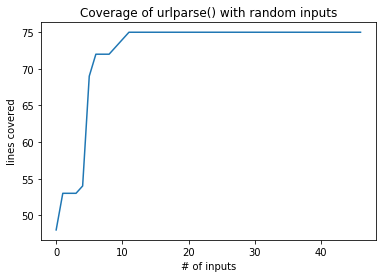

In [52]:
plt.plot(cumulative_coverage)
plt.title('Coverage of urlparse() with random inputs')
plt.xlabel('# of inputs')
plt.ylabel('lines covered');

这种策略的好处是，应用于较大的程序时，它将很乐于探索另一条路径 --- 涵盖函数与函数之间的关系。我们所需要做的只是捕获覆盖范围的一种方法。

## 小结

本章介绍了一个 `MutationFuzzer` 类，该类使用 _种子输入_ 列表，然后将其变异：

In [53]:
seed_input = "http://www.google.com/search?q=fuzzing"
mutation_fuzzer = MutationFuzzer(seed=[seed_input])
[mutation_fuzzer.fuzz() for i in range(10)]

['http://www.google.com/search?q=fuzzing',
 'http://www.g=oNogl.om/search?q=fuzzing/',
 'RttpX://w)ww.goo(gle.comq/sarc(q=fuzzng',
 'hdt8p://"wWw.goole.com/seDarb`*?q=fuzzing',
 'httop://www.CooglGe.om/s$arch?q=fuzzingY',
 'http://wwlw.google.c"om/secrch?yq=fuzzin',
 'hup://www.google.comC/search?q=fuzzing',
 'http://w7w.google.com/search?q=ufuzgzing',
 'http://www,google.com/sear4ch?.q=fuzzing',
 'http://w&ww.google.cKom/search7q=fuzzing']

`MutationCoverageFuzzer` 包含了输入的 _总体数量_ ，然后对其进行演化以实现最大化覆盖率。

In [54]:
mutation_fuzzer = MutationCoverageFuzzer(seed=[seed_input])
mutation_fuzzer.runs(http_runner, trials=10000)
mutation_fuzzer.population[:5]

['http://www.google.com/search?q=fuzzing',
 'htTp://www.googld.cqom/searchq=fuzzIng',
 'htTp://www.gloogld.qom/|searchq=fuzzng',
 'htTp://www.googld.cqomo0searchq=fuzzIng',
 'htTp://www*goegld.cqoe/sa7#hq=fuzIng']

## 本节学到的

* 随机生成的输入通常是无效的-因此需要对输入进行相关处理。
* 来自现有有效输入的变异具有较高得到有效输入的概率，因此可以使用对输入的变异处理。


## 下一步

下一章 [灰盒模糊测试](GreyboxFuzzer.ipynb)，我们将通过 _power schedules_ 进一步扩展基于突变的测试的概念，该计划允许将更多的精力花费在使用“不太可能”路径的种子和“接近”目标位置的种子上。

## 练习

### 练习 1: Fuzzing CGI decode with Mutations

Apply the above _guided_ mutation-based fuzzing technique on `cgi_decode()` from the ["Coverage"](Coverage.ipynb) chapter.  How many trials do you need until you cover all variations of `+`, `%` (valid and invalid), and regular characters?

In [55]:
from Coverage import cgi_decode

In [56]:
seed = ["Hello World"]
cgi_runner = FunctionCoverageRunner(cgi_decode)
m = MutationCoverageFuzzer(seed)
results = m.runs(cgi_runner, 10000)

In [57]:
m.population

['Hello World', 'he_<+llo(or<D', 'L}eml &Wol%dD', 'L)q<}aml &cWol%d3D+']

In [58]:
cgi_runner.coverage()

{('__exit__', 80),
 ('cgi_decode', 10),
 ('cgi_decode', 11),
 ('cgi_decode', 12),
 ('cgi_decode', 13),
 ('cgi_decode', 16),
 ('cgi_decode', 17),
 ('cgi_decode', 18),
 ('cgi_decode', 19),
 ('cgi_decode', 20),
 ('cgi_decode', 21),
 ('cgi_decode', 22),
 ('cgi_decode', 23),
 ('cgi_decode', 24),
 ('cgi_decode', 25),
 ('cgi_decode', 26),
 ('cgi_decode', 27),
 ('cgi_decode', 31),
 ('cgi_decode', 32),
 ('cgi_decode', 33),
 ('run_function', 7)}

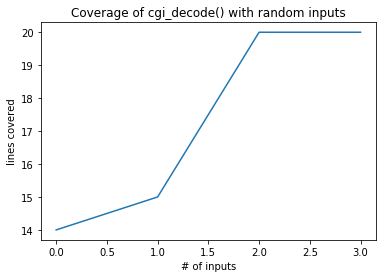

In [59]:
all_coverage, cumulative_coverage = population_coverage(
    m.population, cgi_decode)

import matplotlib.pyplot as plt
plt.plot(cumulative_coverage)
plt.title('Coverage of cgi_decode() with random inputs')
plt.xlabel('# of inputs')
plt.ylabel('lines covered');

After 10,000 runs, we have managed to synthesize a `+` character and a valid `%xx` form.  We can still do better.

### 练习 2: Fuzzing bc with Mutations

Apply the above mutation-based fuzzing technique on `bc`, as in the chapter ["Introduction to Fuzzing"](Fuzzer.ipynb).

#### Part 1: Non-Guided Mutations

Start with non-guided mutations.  How many of the inputs are valid?

**解决方案.** This is just a matter of tying a `ProgramRunner` to a `MutationFuzzer`:

In [60]:
from Fuzzer import ProgramRunner

In [61]:
seed = ["1 + 1"]
bc = ProgramRunner(program="bc")
m = MutationFuzzer(seed)
outcomes = m.runs(bc, trials=100)

In [62]:
outcomes[:3]

[(CompletedProcess(args='bc', returncode=0, stdout='', stderr='(standard_in) 1: parse error\n'),
  'PASS'),
 (CompletedProcess(args='bc', returncode=0, stdout='', stderr='(standard_in) 1: illegal character: `\n(standard_in) 1: parse error\n'),
  'PASS'),
 (CompletedProcess(args='bc', returncode=0, stdout='', stderr='(standard_in) 1: parse error\n'),
  'PASS')]

In [63]:
sum(1 for completed_process, outcome in outcomes if completed_process.stderr == "")

5

#### Part 2: Guided Mutations

Continue with _guided_ mutations.  To this end, you will have to find a way to extract coverage from a C program such as `bc`.  Proceed in these steps:

First, get [GNU bc](https://www.gnu.org/software/bc/); download, say, `bc-1.07.1.tar.gz` and unpack it:

In [64]:
!curl -O mirrors.kernel.org/gnu/bc/bc-1.07.1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  410k  100  410k    0     0   345k      0  0:00:01  0:00:01 --:--:--  345k


In [65]:
!tar xfz bc-1.07.1.tar.gz

Second, configure the package:

In [66]:
!cd bc-1.07.1; ./configure

checking for a BSD-compatible install... /usr/bin/install -c
checking whether build environment is sane... yes
checking for a thread-safe mkdir -p... ./install-sh -c -d
checking for gawk... no
checking for mawk... no
checking for nawk... no
checking for awk... awk
checking whether make sets $(MAKE)... yes
checking whether make supports nested variables... yes
checking for gcc... gcc
checking whether the C compiler works... yes
checking for C compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether we are using the GNU C compiler... yes
checking whether gcc accepts -g... yes
checking for gcc option to accept ISO C89... none needed
checking whether gcc understands -c and -o together... yes
checking for style of include used by make... GNU
checking dependency style of gcc... gcc3
checking how to run the C preprocessor... gcc -E
checking for grep that handles lon

Third, compile the package with special flags:

In [67]:
!cd bc-1.07.1; make CFLAGS="--coverage"

/Library/Developer/CommandLineTools/usr/bin/make  all-recursive
Making all in lib
gcc -DHAVE_CONFIG_H  -I. -I..  -I. -I.. -I./../h  -g -O2 -Wall -funsigned-char --coverage -MT getopt.o -MD -MP -MF .deps/getopt.Tpo -c -o getopt.o getopt.c
mv -f .deps/getopt.Tpo .deps/getopt.Po
gcc -DHAVE_CONFIG_H  -I. -I..  -I. -I.. -I./../h  -g -O2 -Wall -funsigned-char --coverage -MT getopt1.o -MD -MP -MF .deps/getopt1.Tpo -c -o getopt1.o getopt1.c
mv -f .deps/getopt1.Tpo .deps/getopt1.Po
gcc -DHAVE_CONFIG_H  -I. -I..  -I. -I.. -I./../h  -g -O2 -Wall -funsigned-char --coverage -MT vfprintf.o -MD -MP -MF .deps/vfprintf.Tpo -c -o vfprintf.o vfprintf.c
mv -f .deps/vfprintf.Tpo .deps/vfprintf.Po
gcc -DHAVE_CONFIG_H  -I. -I..  -I. -I.. -I./../h  -g -O2 -Wall -funsigned-char --coverage -MT number.o -MD -MP -MF .deps/number.Tpo -c -o number.o number.c
mv -f .deps/number.Tpo .deps/number.Po
rm -f libbc.a
ar cru libbc.a getopt.o getopt1.o vfprintf.o number.o 
ranlib libbc.a
Making all in bc
gcc -DHAVE_CONFIG_H

The file `bc/bc` should now be executable...

In [68]:
!cd bc-1.07.1/bc; echo 2 + 2 | ./bc

4


...and you should be able to run the `gcov` program to retrieve coverage information.

In [69]:
!cd bc-1.07.1/bc; gcov main.c

File 'main.c'
Lines executed:52.42% of 124
main.c:creating 'main.c.gcov'



As sketched in the ["Coverage" chapter](Coverage.ipynb), the file [bc-1.07.1/bc/main.c.gcov](bc-1.07.1/bc/main.c.gcov) now holds the coverage information for `bc.c`.  Each line is prefixed with the number of times it was executed. `#####` means zero times; `-` means non-executable line.

Parse the GCOV file for `bc` and create a `coverage` set, as in `FunctionCoverageRunner`.  Make this a `ProgramCoverageRunner` class that would be constructed with a list of source files (`bc.c`, `main.c`, `load.c`) to run `gcov` on.

When you're done, don't forget to clean up:

In [70]:
!rm -fr bc-1.07.1 bc-1.07.1.tar.gz

### 练习 3

In this [blog post](https://lcamtuf.blogspot.com/2014/08/binary-fuzzing-strategies-what-works.html), the author of _American Fuzzy Lop_ (AFL), a very popular mutation-based fuzzer discusses the efficiency of various mutation operators.  Implement four of them and evaluate their efficiency as in the examples above.

### 练习 4

When adding a new element to the list of candidates, AFL does actually not compare the _coverage_, but adds an element if it exercises a new _branch_.  Using branch coverage from the exercises of the ["Coverage"](Coverage.ipynb) chapter, implement this "branch" strategy and compare it against the "coverage" strategy, above.

### 练习 5

Design and implement a system that will gather a population of URLs from the Web.  Can you achieve a higher coverage with these samples?  What if you use them as initial population for further mutation?